In [2]:
# !pip install xgboost

     |████████████████████████████████| 173.5 MB 9.8 kB/s s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [20]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 106.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
# from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import joblib

In [2]:
# Display the dataframe
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
pd.set_option('display.max_colwidth', 100)  # or 199

import warnings
warnings.filterwarnings("ignore")

In [12]:
df_train_validation = pd.read_csv("final2_train_val.csv", low_memory=False, index_col="id")
df_test = pd.read_csv("final2_test.csv", low_memory=False, index_col="id")

In [13]:
X_train_val, y_train_val = df_train_validation.drop("ARRIVAL_DELAY", axis=1), df_train_validation["ARRIVAL_DELAY"]
X_test = df_test

In [6]:
df_train_validation.columns

Index(['MONTH', 'A_RANK', 'D_RANK', 'O_RANK', 'DAY', 'DAY_OF_WEEK',
       'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT',
       'DEPARTURE_DELAY', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', 'avg_dep_delay_by_origin',
       'avg_dep_delay_by_dest', 'avg_dep_delay_by_airline', 'AIRLINE_AA',
       'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9',
       'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA',
       'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN'],
      dtype='object')

In [ ]:
df_test.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,TAXI_OUT,SCHEDULED_ARRIVAL,LATITUDE_origin,LONGITUDE_origin,LATITUDE_arrival,LONGITUDE_arrival,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,scaled_DEPARTURE_TIME,scaled_WHEELS_OFF,scaled_SCHEDULED_TIME,scaled_DISTANCE
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,1,3,298,3,11.0,500,36.08036,-115.15233,29.98047,-95.33972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.578947,-1.583333,0.606742,0.832849
1,7,1,3,1965,5,21.0,808,37.61900,-122.37484,35.21401,-80.94313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.308446,-1.621324,2.022472,2.393895
2,7,1,3,2020,5,36.0,548,33.94254,-118.40807,35.04242,-89.97667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.308446,-1.602941,1.123596,1.409884
3,7,1,3,612,5,14.0,503,36.08036,-115.15233,44.88055,-93.21692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.564259,-1.515931,0.617978,0.944767
4,7,1,3,1044,8,20.0,912,61.17432,-149.99619,41.97960,-87.90446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.608323,-1.601716,2.707865,3.193314


In [28]:
def missingValuesInfo(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2)
    temp = pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])
    return temp.loc[(temp['Total'] > 0)]

missingValuesInfo(df_train_validation)

,Total,Percent


In [17]:
# Split: for XGBoost
df_train, df_validation = train_test_split(df_train_validation, test_size=0.20, random_state = 42)
X_train, y_train = df_train.drop("ARRIVAL_DELAY", axis=1), df_train["ARRIVAL_DELAY"]
X_val, y_val = df_validation.drop("ARRIVAL_DELAY", axis=1), df_validation["ARRIVAL_DELAY"]

In [9]:
X_test = df_test

## XGBoost Regressor

#### Without tuning: using preprocessing version 2

In [4]:
df_train_validation = pd.read_csv("final2_train_val.csv", low_memory=False, index_col="id")
X_train_val, y_train_val = df_train_validation.drop("ARRIVAL_DELAY", axis=1), df_train_validation["ARRIVAL_DELAY"]
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train_val,y_train_val)
joblib.dump(xg_reg, "xgreg-without-tuning.pkl")

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


['xgreg-without-tuning.pkl']

In [5]:
X_test = pd.read_csv("final2_test.csv", low_memory=False, index_col="id")
eval_pred = xg_reg.predict(X_test)
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

MONTH                            0.003615
A_RANK                           0.003422
D_RANK                           0.002431
O_RANK                           0.002705
DAY                              0.002611
DAY_OF_WEEK                      0.001744
FLIGHT_NUMBER                    0.001157
SCHEDULED_DEPARTURE              0.025282
DEPARTURE_TIME                   0.007000
TAXI_OUT                         0.050055
DEPARTURE_DELAY                  0.775350
WHEELS_OFF                       0.005809
SCHEDULED_TIME                   0.005610
DISTANCE                         0.003810
SCHEDULED_ARRIVAL                0.001883
average_delay_origin_airport     0.003452
average_delay_arrival_airport    0.002242
average_delay_airline            0.010007
sd_delay_origin_airport          0.003851
sd_delay_arrival_airport         0.002652
sd_delay_airline                 0.005245
avg_dep_delay_by_origin          0.003320
avg_dep_delay_by_dest            0.002166
avg_dep_delay_by_airline         0

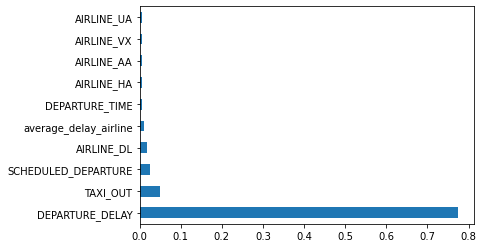

In [45]:
import matplotlib.pyplot as plt
ft_importances = pd.Series(xg_reg.feature_importances_, index=X_train_val.columns)
print(ft_importances)
ft_importances.nlargest(10).plot(kind='barh')
plt.show()

### Hyperparameter tuning

In [22]:
# Hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    reg = xgb.XGBRegressor(n_estimators =space['n_estimators'], 
                           max_depth = int(space['max_depth']),
                           gamma = space['gamma'], 
                           reg_alpha = int(space['reg_alpha']),
                           min_child_weight=int(space['min_child_weight']),
                           colsample_bytree=int(space['colsample_bytree']))

    eval_set  = [(X_train, y_train), (X_val, y_val)]

    reg.fit(X_train, y_train, eval_set=eval_set, eval_metric = 'rmse',
            early_stopping_rounds=10,verbose=False)
    val_pred = reg.predict(X_val)
    mse = mean_squared_error(y_val, val_pred)
    return{'loss':mse, 'status': STATUS_OK }

trials = Trials()
best_hyperparams = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best_hyperparams)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 100/100 [2:37:20<00:00, 94.40s/trial, best loss: 744.9982538396694]  
{'colsample_bytree': 0.8443443748974826, 'gamma': 8.265472386809305, 'max_depth': 14.0, 'min_child_weight': 10.0, 'reg_alpha': 164.0, 'reg_lambda': 0.4112998083884938}
The best hyperparameters are :  

{'colsample_bytree': 0.8443443748974826, 'gamma': 8.265472386809305, 'max_depth': 14.0, 'min_child_weight': 10.0, 'reg_alpha': 164.0, 'reg_lambda': 0.4112998083884938}


In [23]:
best_hyperparams = {'colsample_bytree': 0.8443443748974826, 'gamma': 8.265472386809305, 'max_depth': 14, 'min_child_weight': 10, 'reg_alpha': 164.0, 'reg_lambda': 0.4112998083884938}

xg_reg = xgb.XGBRegressor(**best_hyperparams)
xg_reg.fit(X_train,y_train)
val_pred = xg_reg.predict(X_val)
mse = mean_squared_error(y_val, val_pred)
print(mse)

# 100.04

82.01765643779274


In [41]:
best_hyperparams = {'colsample_bytree': 0.8443443748974826, 'gamma': 8.265472386809305, 'max_depth': 14, 'min_child_weight': 10, 'reg_alpha': 164.0, 'reg_lambda': 0.4112998083884938}
X_train_val, y_train_val = df_train_validation.drop("ARRIVAL_DELAY", axis=1), df_train_validation["ARRIVAL_DELAY"]
xg_reg = xgb.XGBRegressor(**best_hyperparams)
xg_reg.fit(X_train_val,y_train_val)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8443443748974826,
             enable_categorical=False, gamma=8.265472386809305, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=14,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=164.0, reg_lambda=0.4112998083884938,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
joblib.dump(xg_reg, "xgreg.pkl")

['xgreg.pkl']

In [43]:
eval_pred = xg_reg.predict(X_test)

In [44]:
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

## Gradient Boosting Regressor

In [ ]:
df_train, df_validation = train_test_split(df_train_validation, test_size=0.20, random_state = 0)
X_train, y_train = df_train.drop("ARRIVAL_DELAY", axis=1), df_train["ARRIVAL_DELAY"]
X_val, y_val = df_validation.drop("ARRIVAL_DELAY", axis=1), df_validation["ARRIVAL_DELAY"]

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
val_pred = xg_reg.predict(X_val)
mse = mean_squared_error(y_val, val_pred)
print(mse)

In [ ]:
gbr.fit(X_train_val, y_train_val)
joblib.dump(gbr, "gradient_boosting_regressor.pkl")

In [48]:
eval_pred = gbr.predict(X_test)
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

## Light GBM

In [49]:
# Light GBM
lgbm = LGBMRegressor()
xg_reg.fit(X_train, y_train)
val_pred = xg_reg.predict(X_val)
mse = mean_squared_error(y_val, val_pred)
print(mse)
# 176.54

NameError: name 'LGBMRegressor' is not defined

In [ ]:
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

In [ ]:
# grid.fit(np.array(X_train_val), np.array(y_train_val))
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: nan using {'lasso__alpha': 0.2, 'meta_regressor__n_estimators': 10, 'ridge__alpha': 0.05}


In [ ]:
joblib.dump(grid, "stackingCV.pkl")
eval_pred = grid.predict(np.array(X_test))

In [ ]:
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

## CatBoostRegressor

In [3]:
# !pip install catboost

     |████████████████████████████████| 76.3 MB 89 kB/s s eta 0:00:01
     |████████████████████████████████| 46 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 25.3 MB 64.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import catboost as cb

In [13]:
flights_train_validation = pd.read_csv("final4_train_val.csv", low_memory=False, index_col="id")
flights_test = pd.read_csv("final4_test.csv", low_memory=False, index_col="id")

In [14]:
X_train_val, y_train_val = flights_train_validation.drop("ARRIVAL_DELAY", axis=1), flights_train_validation["ARRIVAL_DELAY"]
X_test = flights_test

In [7]:
X_test.head()

,MONTH,A_RANK,D_RANK,O_RANK,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,CROSS_DAY,MULTI_DAY,TOTALTIME_LEFT,TAKEOFF_DELAY,SCHEDULED_TIME2,AIRTIME_LEFT,DEPARTURE_DELAY_COR,TAXI_OUT2,TAXI_OUT_COMP,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,12,233,200,1,3,298,3,41,11,38,52,177,1222,300,False,False,-259,-49,-297,-248,38,-11,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7,7,57,191,1,3,1965,5,1440,21,1435,21,303,2296,488,False,False,952,-16,-483,-467,1435,1419,-1398,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1,199,188,1,3,2020,5,1440,36,1435,36,223,1619,348,False,False,1092,-31,-343,-312,1435,1404,-1368,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,12,85,200,1,3,612,5,53,14,48,67,178,1299,303,False,False,-250,-62,-298,-236,48,-14,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,7,9,274,33,1,3,1044,8,17,20,9,37,364,2846,552,False,False,-535,-29,-544,-515,9,-20,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
cbr = cb.CatBoostRegressor(loss_function="RMSE")
cbr.fit(X_train_val, y_train_val)
cbr.predict(X_test)
eval_pred = cbr.predict(X_test)
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

Learning rate set to 0.143643
0:	learn: 35.8068444	total: 185ms	remaining: 3m 5s
1:	learn: 31.7120705	total: 361ms	remaining: 3m
2:	learn: 28.2290616	total: 535ms	remaining: 2m 57s
3:	learn: 25.2831482	total: 716ms	remaining: 2m 58s
4:	learn: 22.8478212	total: 898ms	remaining: 2m 58s
5:	learn: 20.8538569	total: 1.08s	remaining: 2m 58s
6:	learn: 19.1642688	total: 1.25s	remaining: 2m 58s
7:	learn: 17.8062989	total: 1.44s	remaining: 2m 58s
8:	learn: 16.6892071	total: 1.63s	remaining: 2m 59s
9:	learn: 15.7774258	total: 1.81s	remaining: 2m 59s
10:	learn: 15.0233507	total: 1.99s	remaining: 2m 58s
11:	learn: 14.4303322	total: 2.16s	remaining: 2m 57s
12:	learn: 13.9630393	total: 2.35s	remaining: 2m 58s
13:	learn: 13.5642259	total: 2.52s	remaining: 2m 57s
14:	learn: 13.2479869	total: 2.7s	remaining: 2m 57s
15:	learn: 13.0011130	total: 2.9s	remaining: 2m 58s
16:	learn: 12.7813267	total: 3.09s	remaining: 2m 58s
17:	learn: 12.6081727	total: 3.25s	remaining: 2m 57s
18:	learn: 12.4699828	total: 3.44

In [13]:
joblib.dump(cbr, "catboost.pkl")

['catboost.pkl']

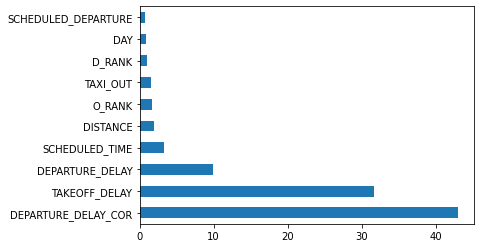

In [16]:
import matplotlib.pyplot as plt
ft_importances = pd.Series(cbr.feature_importances_, index=X_train_val.columns)
ft_importances.nlargest(10).plot(kind='barh')
plt.show()

In [17]:
ft_importances.sort_values(ascending=False)

DEPARTURE_DELAY_COR    43.005111
TAKEOFF_DELAY          31.567300
DEPARTURE_DELAY         9.908817
SCHEDULED_TIME          3.318781
DISTANCE                1.924079
O_RANK                  1.736916
TAXI_OUT                1.549500
D_RANK                  1.013563
DAY                     0.850808
SCHEDULED_DEPARTURE     0.740849
SCHEDULED_TIME2         0.569465
TOTALTIME_LEFT          0.459061
AIRTIME_LEFT            0.429930
AIRLINE_AA              0.376219
AIRLINE_DL              0.351939
A_RANK                  0.347444
DAY_OF_WEEK             0.264437
SCHEDULED_ARRIVAL       0.257121
TAXI_OUT2               0.223535
AIRLINE_UA              0.196693
WHEELS_OFF              0.194398
AIRLINE_HA              0.178923
DEPARTURE_TIME          0.139705
FLIGHT_NUMBER           0.130273
AIRLINE_WN              0.054816
TAXI_OUT_COMP           0.041801
AIRLINE_EV              0.031616
AIRLINE_VX              0.029265
AIRLINE_B6              0.028300
AIRLINE_OO              0.024140
AIRLINE_US

## Stacking CV Regressor

In [11]:
# !pip install mlxtend  

     |████████████████████████████████| 1.3 MB 12.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
# Stacking CV Regressor
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
from mlxtend.regressor import StackingCVRegressor

In [3]:
flights_train_validation = pd.read_csv("final4_train_val.csv", low_memory=False, index_col="id")
flights_test = pd.read_csv("final4_test.csv", low_memory=False, index_col="id")
X_train_val, y_train_val = flights_train_validation.drop("ARRIVAL_DELAY", axis=1), flights_train_validation["ARRIVAL_DELAY"]
X_test = flights_test

In [12]:
X_test.head()

,MONTH,A_RANK,D_RANK,O_RANK,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,TOTALTIME_LEFT,TAKEOFF_DELAY,SCHEDULED_TIME2,AIRTIME_LEFT,DEPARTURE_DELAY_COR,TAXI_OUT2,TAXI_OUT_COMP,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,12,233,200,1,3,298,3,41,11,38,52,177,1222,300,-259,-49,-297,-248,38,-11,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7,7,57,191,1,3,1965,5,1440,21,1435,21,303,2296,488,952,-16,-483,-467,1435,1419,-1398,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1,199,188,1,3,2020,5,1440,36,1435,36,223,1619,348,1092,-31,-343,-312,1435,1404,-1368,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,12,85,200,1,3,612,5,53,14,48,67,178,1299,303,-250,-62,-298,-236,48,-14,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,7,9,274,33,1,3,1044,8,17,20,9,37,364,2846,552,-535,-29,-544,-515,9,-20,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
ada = AdaBoostRegressor()
ada.fit(X_train_val, y_train_val)
joblib.dump(ada, "adaboost.pkl")

['adaboost.pkl']

In [5]:
eval_pred = ada.predict(X_test)
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

In [6]:
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train_val, y_train_val)
joblib.dump(xgboost, "xgboost.pkl")
eval_pred = xgboost.predict(X_test)
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

In [10]:
catboost = joblib.load("catboost.pkl")
xgboost = joblib.load("xgboost.pkl")

In [11]:
stack = StackingCVRegressor(regressors=(xgboost, catboost), meta_regressor=catboost, use_features_in_secondary=True)
stack.fit(X_train_val, y_train_val)

Learning rate set to 0.138667
0:	learn: 35.8988653	total: 227ms	remaining: 3m 46s
1:	learn: 31.8882070	total: 370ms	remaining: 3m 4s
2:	learn: 28.4791372	total: 517ms	remaining: 2m 51s
3:	learn: 25.6157081	total: 659ms	remaining: 2m 44s
4:	learn: 23.2103571	total: 814ms	remaining: 2m 41s
5:	learn: 21.2096810	total: 967ms	remaining: 2m 40s
6:	learn: 19.5725467	total: 1.11s	remaining: 2m 38s
7:	learn: 18.2038617	total: 1.27s	remaining: 2m 37s
8:	learn: 17.0572078	total: 1.43s	remaining: 2m 37s
9:	learn: 16.0670078	total: 1.57s	remaining: 2m 35s
10:	learn: 15.2868203	total: 1.72s	remaining: 2m 34s
11:	learn: 14.6632366	total: 1.88s	remaining: 2m 34s
12:	learn: 14.1610377	total: 2.02s	remaining: 2m 33s
13:	learn: 13.7362789	total: 2.17s	remaining: 2m 32s
14:	learn: 13.3983368	total: 2.32s	remaining: 2m 32s
15:	learn: 13.1208127	total: 2.46s	remaining: 2m 31s
16:	learn: 12.8934182	total: 2.63s	remaining: 2m 31s
17:	learn: 12.7051008	total: 2.77s	remaining: 2m 31s
18:	learn: 12.5580648	total

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7fd998f2af90>,
                    regressors=(XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1,
                                             enable_categorical=False, gamma=0,
                                             gpu_id=-1, importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.300000012,
                                             max_delta_step=0, max_depth=6,
                                             min_child_weight=1, missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=100, n_jobs=4,
                            

In [12]:
joblib.dump(stack, "stackingcv.pkl")

['stackingcv.pkl']

In [14]:
eval_pred = stack.predict(X_test)
pd.DataFrame(eval_pred, columns=['ARRIVAL_DELAY']).to_csv("flight_result.csv", index_label='id')

## Calculating errors and R2

In [17]:
catboost = joblib.load("catboost.pkl")

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(catboost, X_train_val, y_train_val, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print(scores)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
flights_train_validation = pd.read_csv("final4_train_val.csv", low_memory=False, index_col="id")
flights_test = pd.read_csv("final4_test.csv", low_memory=False, index_col="id")

